# Design Single Country Nat Cat Bonds

In [79]:
#import general packages
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

#import climada stuff
from climada.entity.impact_funcs import trop_cyclone, impact_func_set
from climada.util.api_client import Client
from climada.engine import ImpactCalc

%load_ext autoreload
%autoreload 2
import haz_storm as hst
import exposures as ex
import grider as grd
import impact as cimp
import functions as fct
import pay_opt as popt

client = Client()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Perform natural hazard simulation 
### Define variables for cat bonds

In [45]:
#choose storm basin to load
#The STORM basins are: 'EP','NA','NI','SI','SP','WP'
basins = ['SI']

#choose country
country = 174

#number of simulated years
r = 10000

#define maximum and minimum return periods to be covered
upper_rp = 200
lower_rp = 100

### Load TC Tracks for basin

In [46]:
storms_basin = hst.init_STORM_tracks(basins=basins)

----------------------Initiating Hazard----------------------


### Generate Exposure Data and TC hazards impacting selected exposure
1. Generate exposure data using newest available data. Can choose fin_mode myself, reference year, and resolution. <br>
2. Generate centroids at the locations of the exposed assets <br>
3. Filter tc tracks so that dataset only includes tracks which affect chosen exposure locations <br>
4. Generate tc hazards


STORM basin of country:  SI


c:\users\kaibe\climada\climada_python\climada\hazard\tc_tracks.py:308: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  exp_buffer = exposure.gdf.buffer(distance=buffer, resolution=0)
c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\shapely\constructive.py:181: RuntimeWarning: divide by zero encountered in buffer
  return lib.buffer(
c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\geopandas\geodataframe.py:204: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry colu

Number of tracks in SI basin: 219


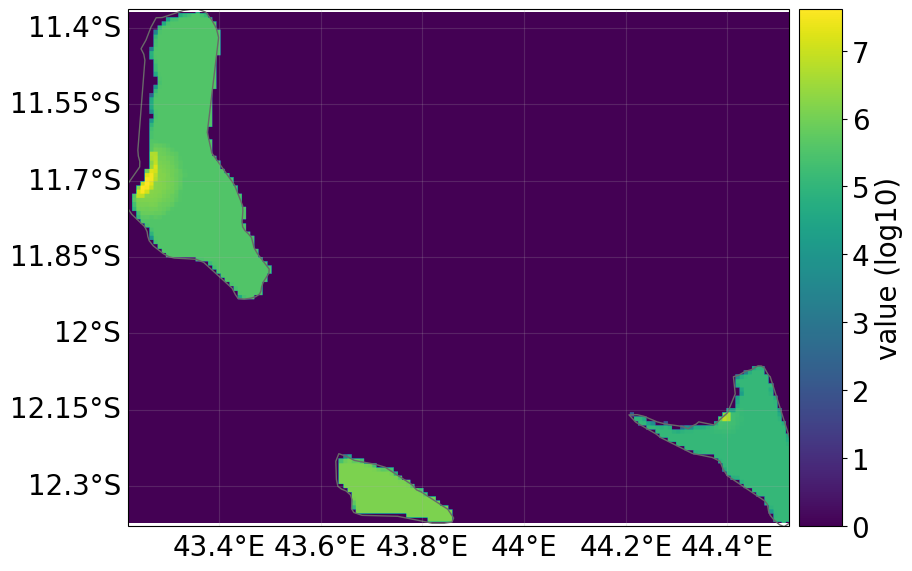

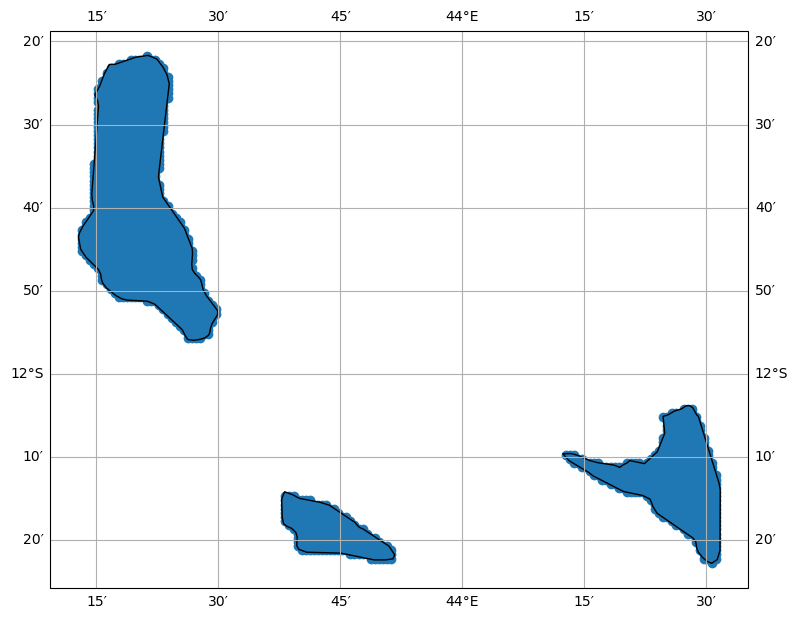

In [47]:
exp, centrs, applicable_basins, storm_basin_sub, tc_storms = ex.init_TC_exp(storms_basin, country, load_fls=False)

c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\grider.py:100: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


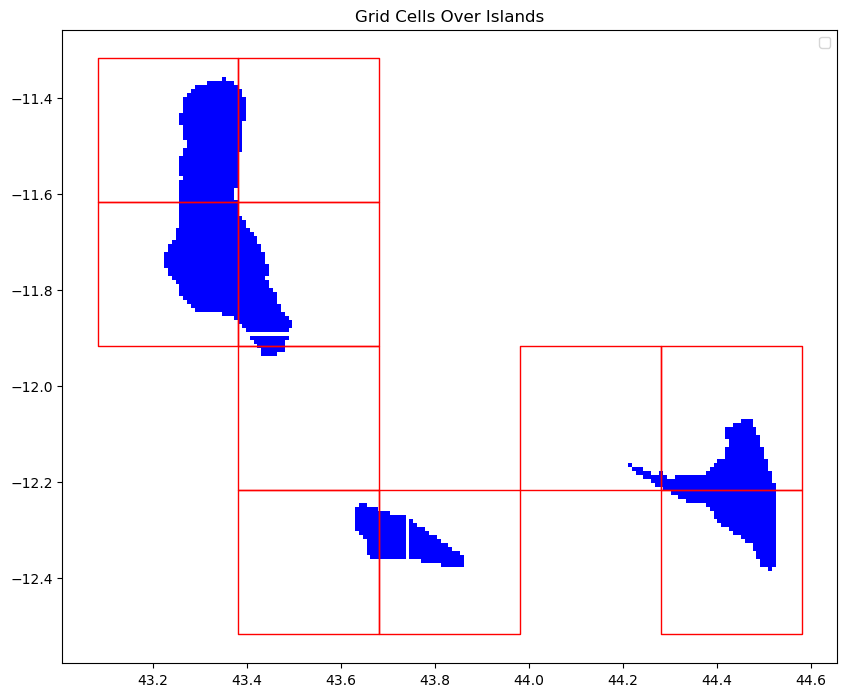

In [48]:
rst_grid = grd.init_grid(exp)

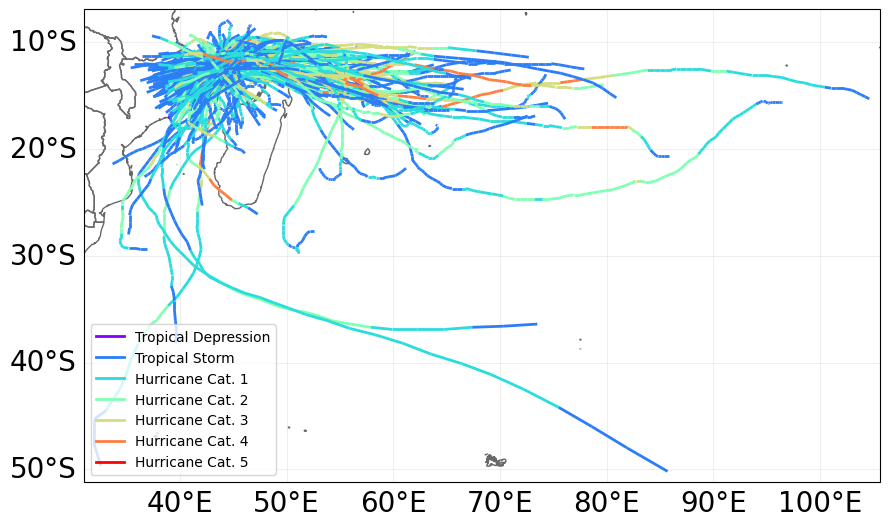

In [49]:
#plot filtered tc hazards
ax_sub = storm_basin_sub.plot()
ax_sub.get_legend()._loc = 3

### Calculate Impact
1. Calculate impact matrix
2. Determine exposure points per grid cell
3. Calculate total impacts per grid cell and event

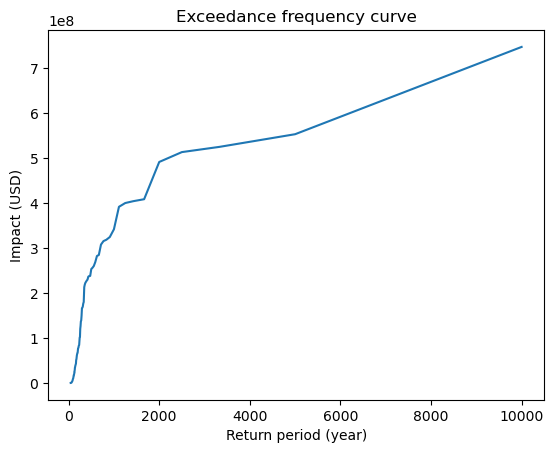

In [51]:
imp, imp_per_exp, agg_exp, imp_grid_evt = cimp.init_imp(exp, tc_storms, rst_grid) 

## Optimize insurance policies

### Calculate return periods for grid cells

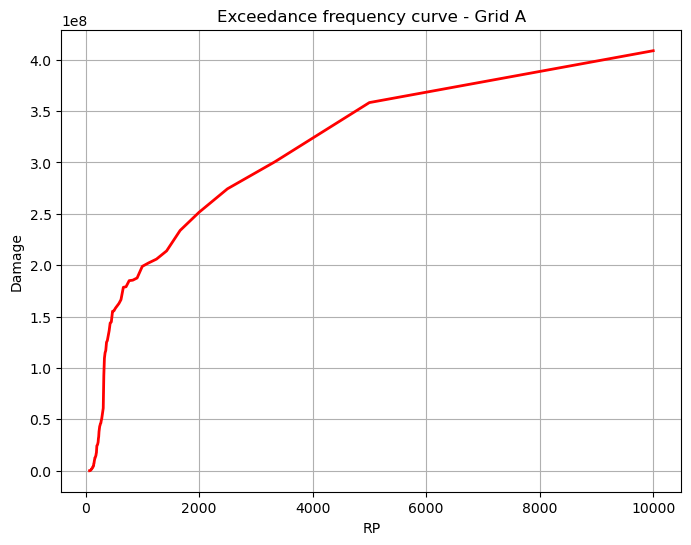

In [52]:
rp_dam_grid = pd.DataFrame(columns=['Grid','Upper','Lower'])

# Create an empty DataFrame
for i in imp_grid_evt:
    number = ord(i) - 65
    df = pd.DataFrame({'Damage': imp_grid_evt[i]})
    rp_dam_grid.loc[number] = [i, fct.calc_rp(df,upper_rp), fct.calc_rp(df,lower_rp)]
    df_name = f'df_grid_{i}'
    globals()[df_name] = df

# Create a plot
plt.figure(figsize=(8, 6))

# Plot a line connecting the points
plt.plot(df_grid_A['RP'], df_grid_A['Damage'], color='red', linestyle='-', linewidth=2)

# Add labels and title
plt.xlabel('RP')
plt.ylabel('Damage')
plt.title('Exceedance frequency curve - Grid A')

# Show the plot
plt.grid(True)
plt.show()

### Create data frame containing maximum wind speeds per grid and event

In [54]:
ws_grid = {letter: [None] * len(tc_storms.event_id) for letter in agg_exp.keys()}

for i in range(len(tc_storms.event_id)):
    for letter, line_numbers in agg_exp.items():
        selected_values = tc_storms.intensity[i, line_numbers]
        ws_grid[letter][i] = selected_values.max()

ws_grid = pd.DataFrame.from_dict(ws_grid)

### Create filtered damage data frame using minimum and maximum bounds to damage
To be used for calibration

In [55]:
imp_grid_evt_flt = imp_grid_evt

for i in range(len(rp_dam_grid)):
    max = rp_dam_grid.loc[i,'Upper']
    min = rp_dam_grid.loc[i,'Lower']
    for j in range(len(imp_grid_evt)):
        sel_val = imp_grid_evt.iloc[j,i]
        if sel_val > max:
            imp_grid_evt_flt.iloc[j,i] = max
        elif sel_val < min:
            imp_grid_evt_flt.iloc[j,i] = 0
        else:
            pass

### Define objective function

In [60]:
def slope(x, y, min_pay, max_pay):
    m = (max_pay - min_pay) / (y - x)
    return m

def intercept(nominal, m, y):
    b = nominal - (m * y)
    return b

def calculate_payout(x, y, haz_int, max_min_pay, grid):
    payout_df = pd.DataFrame(index=np.arange(len(haz_int)), columns=np.arange(1))
    for i in range(len(haz_int)):
        filtered_rows = pd.DataFrame(max_min_pay.iloc[grid]) # Filter rows where 'Grid' has the value 'grid'
        max_pay = filtered_rows.loc['Upper'].iloc[0]
        min_pay = filtered_rows.loc['Lower'].iloc[0]
        m = slope(x, y, min_pay, max_pay)
        b = intercept(max_pay, m, y)
        wind_speed = haz_int.iloc[i, grid]

        if x <= wind_speed <= y:
            payout = m * wind_speed + b
        elif wind_speed > y:
            payout = max_pay
        else:
            payout = 0

        payout_df.iloc[i,0] = payout

    return payout_df

def objective_function(params, damage_matrix):
    """Objective function to minimize.
    
    Parameters
    ----------
    params : list
        List of parameters [x, y] for each grid cell.
    damage_matrix : np.ndarray
        Matrix of damage values.
        
    Returns
    -------
    float
        Sum of squared differences between calculated payout and damage.
    """
    num_cells = damage_matrix.shape[1]  # Number of grid cells
    total_diff = 0

    # Extract parameters for each grid cell
    for cell_idx in range(num_cells):
        x = params[cell_idx * 2]      # x for this grid cell
        y = params[cell_idx * 2 + 1]  # y for this grid cell
        
        # Compute payouts
        payouts = calculate_payout(x, y, ws_grid, rp_dam_grid, cell_idx)
        
        # Compute the squared difference
        diff = np.sum(((payouts.iloc[:, 0] - damage_matrix.iloc[:, cell_idx]) ** 2)** 0.5)
        total_diff += diff

    return total_diff

### Perform optimization

In [64]:
from scipy.optimize import minimize

# Initial guess for parameters [x1, y1, x2, y2, ..., x10, y10]
sequence = [30, 40]
length = 20
initial_params = np.tile(sequence, length // len(sequence))

# Define bounds for x's and for y's
bounds = [(30, 35) if i % 2 == 0 else (40, 45) for i in range(len(initial_params))]


# Perform optimization
result = minimize(
    fun=objective_function,
    x0=initial_params,
    args=(imp_grid_evt_flt,),
    method='L-BFGS-B',  # You can choose other methods as well
    bounds=bounds  # Example bounds, adjust as necessary
)

# Extract the optimized parameters
optimized_params = result.x
print("Optimized parameters:")
print(optimized_params)

print('Missmatch between payment and damage:',result.fun)

# Reshape parameters into a more interpretable form if needed
optimized_xs = optimized_params[0::2]  # Every second element starting from 0
optimized_ys = optimized_params[1::2]  # Every second element starting from 1


Optimized parameters:
[30.13555702 40.         30.20559361 40.         30.         40.
 30.         40.         31.36686572 40.         31.72641531 40.
 30.         40.         31.34212718 40.         32.57438278 40.7453265
 32.09589791 40.76247105]
Missmatch between payment and damage: 469850739.11396956


### Create payout vs damage matrix per event
Plot it on 1:1 scale

In [65]:
payout_evt_grd = {letter: [None] * len(tc_storms.event_id) for letter in agg_exp.keys()}
payout_evt_grd = pd.DataFrame(payout_evt_grd)
pay_dam_df = pd.DataFrame({'pay': [0] * len(tc_storms.event_id), 'damage': [0] * len(tc_storms.event_id)})

for i in range(len(imp_grid_evt_flt)):
    tot_dam = np.sum(imp_grid_evt_flt.iloc[i, :])
    pay_dam_df.loc[i,"damage"] = tot_dam
    for j in range(len(ws_grid.columns)):
        tot_payout = calculate_payout(optimized_xs[j], optimized_ys[j], ws_grid, rp_dam_grid, j)
        payout_evt_grd.iloc[:,j] = tot_payout.iloc[:,0]
    tot_pay = np.sum(payout_evt_grd.iloc[i, :])
    pay_dam_df.loc[i,"pay"] = tot_pay

C:\Users\kaibe\AppData\Local\Temp\ipykernel_28416\3693871451.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3275275.0945708826' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pay_dam_df.loc[i,"pay"] = tot_pay
C:\Users\kaibe\AppData\Local\Temp\ipykernel_28416\3693871451.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '58088954.112997524' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pay_dam_df.loc[i,"damage"] = tot_dam


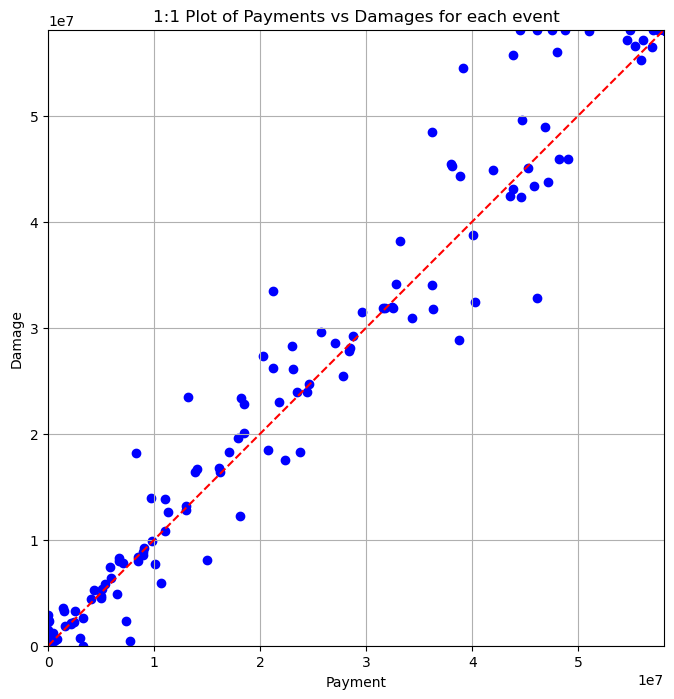

In [66]:
# Create a 1:1 plot (scatter plot with equal scales)
plt.figure(figsize=(8, 8))  # Set the figure size
plt.scatter(pay_dam_df['pay'], pay_dam_df['damage'], color='blue', marker='o')

# Setting equal scaling for x and y axes
plt.xlim(pay_dam_df['pay'].min(), pay_dam_df['pay'].max())
plt.ylim(pay_dam_df['damage'].min(), pay_dam_df['damage'].max())

# Add a 1:1 line for reference
plt.plot([pay_dam_df['pay'].min(), pay_dam_df['pay'].max()], [pay_dam_df['pay'].min(), pay_dam_df['pay'].max()], color='red', linestyle='--')

# Set axis labels
plt.xlabel('Payment')
plt.ylabel('Damage')

# Set aspect ratio to 1 to make the plot square
plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.title('1:1 Plot of Payments vs Damages for each event')
plt.grid(True)
plt.show()

### Calculate cat bond metrics
1. Determine needed nominal
2. Perform Monte-Carlo Simulation
3. Calculate Metrics
    - Expected Loss
    - Attachment Probability
    - Value at risk
    - Coverage
    - Basis-Risk
    - Expected Shortfall

In [90]:
#needed nominal so that the probabilty of exceeding the nominal is 1/500
nominal = fct.calc_rp(pay_dam_df, 500, damage=False)
print('Nominal: ', nominal)

#total exposure
tot_exp = exp.gdf['value'].sum()

#percentage of nominal relative to total exposure
max_rel_imp = nominal/tot_exp
print('Covered exposure relative to GDP: ', max_rel_imp)

Nominal:  56108542.01300098
Covered exposure relative to GDP:  0.04580142592026944


In [86]:
#transform payouts to numpy array
payouts = pay_dam_df['pay'].to_numpy()
damages = pay_dam_df['damage'].to_numpy()

# Parameters for the Monte Carlo Simulation
num_simulations = 10000  # Number of Monte Carlo iterations
simulated_losses = []
simulated_damages = []
event_probability = len(payouts) / r

# Monte Carlo Simulation
for _ in range(num_simulations):
    # randomly generate number of events in one year using poisson distribution and calculated yearly event probability
    num_events = np.random.poisson(lam=event_probability)
    # If there are events in the year, sample that many payouts and the associated damages
    if num_events > 0:
        random_indices = np.random.randint(0, len(payouts), size=num_events)
        simulated_payouts = payouts[random_indices]
        selected_damages = damages[random_indices]
        total_damage = np.sum(selected_damages)
        total_loss = np.sum(simulated_payouts)
    else:
        total_loss = 0
        total_damage = 0  # No events, no loss damage

    simulated_losses.append(total_loss)
    simulated_damages.append(total_damage)

# Convert simulated losses to a DataFrame
simulated_losses = pd.Series(simulated_losses)
simulated_damages = pd.Series(simulated_damages)

In [93]:
#Expected Loss
exp_loss_hist = pay_dam_df['pay'].sum() * (1/r)
exp_loss_sim = simulated_losses.mean()

print(f"Expected Loss (historic): {exp_loss_hist}")
print(f"Expected Loss (simulation): {exp_loss_sim}")

print(f"Relative Expected Loss (historic): {exp_loss_hist / nominal}")
print(f"Relative Expected Loss (simulation): {exp_loss_sim / nominal}")

#Attachment Probability
att_prob_hist = (pay_dam_df['pay'] > 0).sum() / r
att_prob_sim = (simulated_losses > 0).sum() / num_simulations

print(f"Attachment Probability (historic): {att_prob_hist}")
print(f"Attachment Probability (simulation): {att_prob_sim}")

#Coverage
cov_hist = pay_dam_df['pay'].sum() / pay_dam_df['damage'].sum()
cov_sim = sum(simulated_losses) / sum(simulated_damages)

print(f"Coverage (historic): {cov_hist}")
print(f"Coverage (simulation): {cov_sim}")

#Basis Risk
ba_ri_hist = (pay_dam_df['damage'].sum() - pay_dam_df['pay'].sum()) / len(payouts)
ba_ri_sim = (sum(simulated_damages) - sum(simulated_losses)) /len(payouts)

print(f"Basis-Risk (historic): {ba_ri_hist}")
print(f"Basis-Risk (simulation): {ba_ri_sim}")

#Value at Risk
VaR_95 = simulated_losses.quantile(0.95)
VaR_99 = simulated_losses.quantile(0.99)

print(f"Value at Risk (95% confidence): {VaR_95}")
print(f"Value at Risk (99% confidence): {VaR_99}")

#Expected shortfall
ES_95 = simulated_losses[simulated_losses > VaR_95].mean()
ES_99 = simulated_losses[simulated_losses > VaR_99].mean()

print(f"Expected Shortfall (95% confidence): {ES_95}")
print(f"Relative Expected Shortfall (95% confidence): {ES_95 / nominal}")


Expected Loss (historic): 378856.48431711714
Expected Loss (simulation): 430542.0154321597
Relative Expected Loss (historic): 0.006752206896221467
Relative Expected Loss (simulation): 0.00767337735014391
Attachment Probability (historic): 0.0139
Attachment Probability (simulation): 0.0154
Coverage (historic): 0.9633834612163162
Coverage (simulation): 0.9683552644486317
Basis-Risk (historic): 657519.6153953151
Basis-Risk (simulation): 642448.2898969258
Value at Risk (95% confidence): 0.0
Value at Risk (99% confidence): 17099972.12547227
Expected Shortfall (95% confidence): 27957273.729361027
Relative Expected Shortfall (95% confidence): 0.4982712565028514


In [97]:
#set premium
p = 0.04

# Parameters for the Monte Carlo Simulation
term = 3 #time until maturation of bond
tot_simulated_ncf = []

# Monte Carlo Simulation
for _ in range(num_simulations):
    simulated_ncf = []
    cur_nominal = nominal
    payout_happened = False
    for i in range(term):
        # randomly generate number of events in one year using poisson distribution and calculated yearly event probability
        num_events = np.random.poisson(lam=event_probability)
        # If there are events in the year, sample that many payouts and the associated damages
        if num_events == 0 and payout_happened == False:
            net_cash_flow = cur_nominal * p
        elif num_events > 0:
            random_indices = np.random.randint(0, len(payouts), size=num_events)
            simulated_payouts = payouts[random_indices]
            sum_simulated_payouts = np.sum(simulated_payouts)
            if sum_simulated_payouts == 0 and payout_happened == False:
                net_cash_flow = cur_nominal * p
            elif sum_simulated_payouts > 0:
                net_cash_flow = 0 - sum_simulated_payouts
                cur_nominal =+ net_cash_flow
                payout_happened = True

        simulated_ncf.append(net_cash_flow)
    tot_ncf = sum(simulated_ncf)
    tot_simulated_ncf.append(tot_ncf)


# Convert simulated losses to a DataFrame
tot_simulated_ncf = pd.Series(tot_simulated_ncf)
